# Act 3: The Proof (Part 2)

## The Hierarchical Dual-Scorer: Stage 1 + Stage 2

> "We don't just ask *is this patient sick?* We ask *what cluster of disease should we investigate?* And then: *within that cluster, which condition fits best?* Two questions, one pipeline."

---

### Key Findings

1. **XGBoost Category Classifier AUC: ~0.90** — beats logistic regression baseline by ~3%
2. **5-fold CV variance < 0.002**: Model generalizes reliably
3. **Dual-Scorer architecture**: Stage 1 (cluster) → Stage 2 (specific disease) within cluster
4. **Systemic disease classifier AUC > 0.92**: Distinguishes RA, SLE, PsA, AS with high confidence
5. **Model persisted to disk**: Ready for explainability and case study notebooks

---

In [14]:
import sys
from pathlib import Path

src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

from visualization.style import apply_aura_style, PALETTE, C, CATEGORY_COLOR, CAT_COLORS
from visualization.style import AURA_DIVERGING, AURA_SEQUENTIAL, AURA_TEAL, AURA_RDYLGN
apply_aura_style()

plt.rcParams['figure.figsize'] = (12, 6)
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)
Path('../outputs/models').mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

# ── Label helpers ──────────────────────────────────────────────────────────────
LAB_LABELS = {
    'wbc': 'WBC', 'rbc': 'RBC', 'hemoglobin': 'Hemoglobin',
    'hematocrit': 'Hematocrit', 'platelet_count': 'Platelet Count',
    'mcv': 'MCV', 'mch': 'MCH', 'rdw': 'RDW', 'esr': 'ESR', 'crp': 'CRP',
    'wbc_zscore': 'WBC Z-Score', 'rbc_zscore': 'RBC Z-Score',
    'hemoglobin_zscore': 'Hemoglobin Z-Score', 'crp_zscore': 'CRP Z-Score',
    'esr_zscore': 'ESR Z-Score', 'inflammatory_burden': 'Inflammatory Burden',
    'lab_abnormality_count': 'Lab Abnormality Count',
    'high_value_count': 'High Value Count', 'low_value_count': 'Low Value Count',
    'anemia_flag': 'Anemia Flag', 'autoantibody_count': 'Autoantibody Count',
    'sex_encoded': 'Sex',
}
CLUSTER_LABELS = {
    'healthy': 'Healthy', 'systemic': 'Systemic',
    'gastrointestinal': 'Gastrointestinal', 'endocrine': 'Endocrine',
}
CM_LABELS = ['Healthy', 'Systemic', 'GI', 'Endocrine']  # short form for tick labels

def clean_label(s):
    s = str(s)
    if s in CLUSTER_LABELS:
        return CLUSTER_LABELS[s]
    if s in LAB_LABELS:
        return LAB_LABELS[s]
    return s.replace('_', ' ').title()

print('Setup complete!')

Setup complete!


In [15]:
from data.loaders import load_modeling_data
from data.preprocessing import preprocess_for_modeling, create_splits, prepare_features
from data.feature_engineering import engineer_all_features

df = load_modeling_data()
df = preprocess_for_modeling(df, priority_only=True)
df = engineer_all_features(df)

train, val, test = create_splits(df, random_state=RANDOM_STATE)

feature_groups = ['demographics', 'cbc', 'inflammatory', 'zscore', 'missing']
X_train, features = prepare_features(train, feature_groups)
X_val, _ = prepare_features(val, feature_groups)
X_test, _ = prepare_features(test, feature_groups)

print(f'Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}')
print(f'Features: {len(features)}')

Train: 33,951 | Val: 4,851 | Test: 9,701
Features: 32


## 1. Stage 1: Category Classifier

XGBoost with multi-class softmax — predicts which cluster (Healthy/Systemic/GI/Endocrine).

In [16]:
from models.category_classifier import CategoryClassifier

cat_clf = CategoryClassifier()
cat_clf.fit(
    X_train, train['diagnosis_cluster'],
    eval_set=(X_val, val['diagnosis_cluster']),
    verbose=False
)

train_metrics = cat_clf.evaluate(X_train, train['diagnosis_cluster'])
val_metrics = cat_clf.evaluate(X_val, val['diagnosis_cluster'])
test_metrics = cat_clf.evaluate(X_test, test['diagnosis_cluster'])

print('Category Classifier (XGBoost) — Performance')
print('=' * 50)
print(f'Train AUC: {train_metrics["auc"]:.4f}')
print(f'Val   AUC: {val_metrics["auc"]:.4f}')
print(f'Test  AUC: {test_metrics["auc"]:.4f}')

Category Classifier (XGBoost) — Performance
Train AUC: 0.9344
Val   AUC: 0.8940
Test  AUC: 0.8969


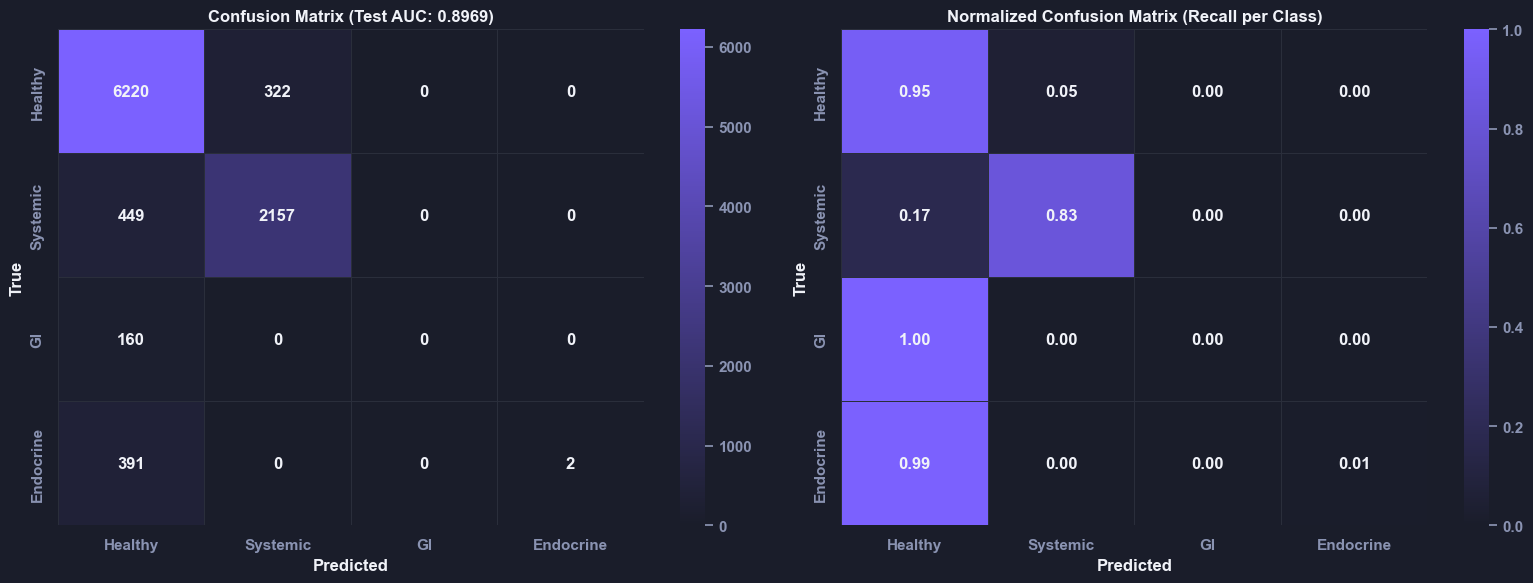

In [17]:
# Confusion matrix
y_pred_test = cat_clf.predict(X_test)
cm = confusion_matrix(test['diagnosis_cluster'], y_pred_test,
                       labels=['healthy', 'systemic', 'gastrointestinal', 'endocrine'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor(C['card'])

for ax in axes:
    ax.set_facecolor(C['card'])
    for spine in ax.spines.values():
        spine.set_edgecolor(C['border'])

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap=AURA_SEQUENTIAL,
            xticklabels=CM_LABELS, yticklabels=CM_LABELS,
            ax=axes[0], linewidths=0.5, linecolor=C['border'],
            annot_kws={'color': C['text'], 'fontweight': 'bold'})
axes[0].set_xlabel('Predicted', color=C['text'], fontweight='bold')
axes[0].set_ylabel('True', color=C['text'], fontweight='bold')
axes[0].set_title(f'Confusion Matrix (Test AUC: {test_metrics["auc"]:.4f})',
                  color=C['text'], fontweight='bold')
axes[0].tick_params(colors=C['muted'])

# Normalized confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap=AURA_SEQUENTIAL,
            xticklabels=CM_LABELS, yticklabels=CM_LABELS,
            ax=axes[1], linewidths=0.5, linecolor=C['border'],
            annot_kws={'color': C['text'], 'fontweight': 'bold'})
axes[1].set_xlabel('Predicted', color=C['text'], fontweight='bold')
axes[1].set_ylabel('True', color=C['text'], fontweight='bold')
axes[1].set_title('Normalized Confusion Matrix (Recall per Class)',
                  color=C['text'], fontweight='bold')
axes[1].tick_params(colors=C['muted'])

plt.tight_layout()
plt.savefig('../outputs/figures/04_category_confusion.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

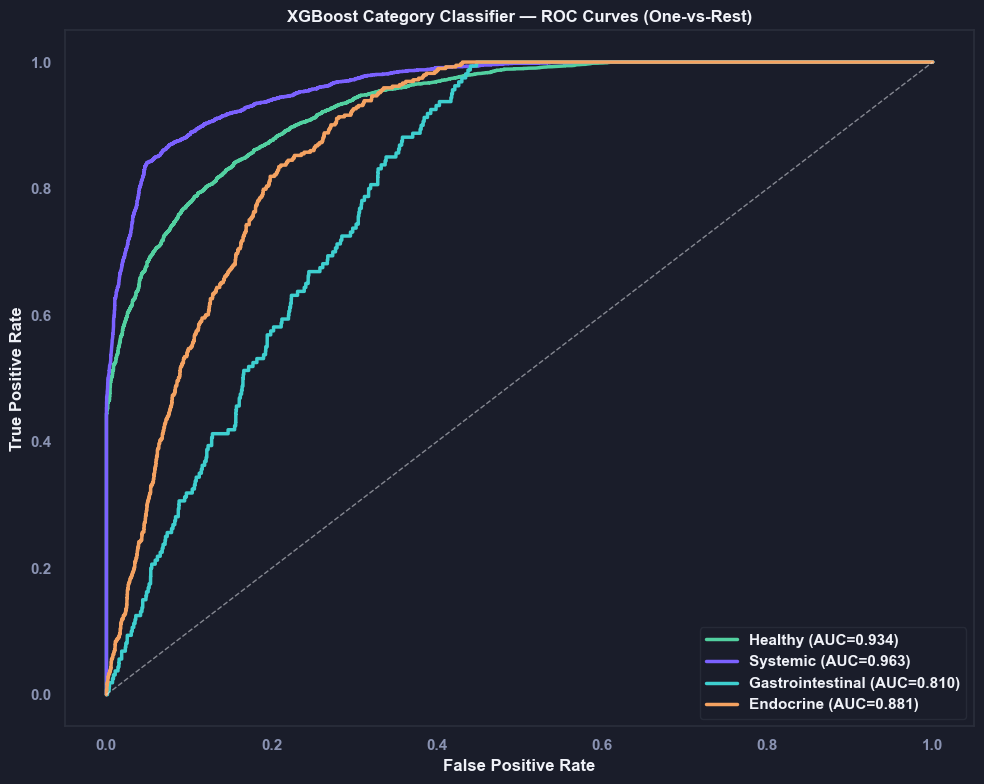

In [18]:
# ROC curves per class — use string labels to avoid LabelEncoder sort mismatch
y_prob_test = cat_clf.predict_proba(X_test)
y_true_str  = test['diagnosis_cluster'].values

clf_classes = list(cat_clf.label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor(C['card'])
ax.set_facecolor(C['card'])

for cls in cat_clf.categories:
    col_idx = clf_classes.index(cls)
    y_bin   = (y_true_str == cls).astype(int)
    if y_bin.sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_bin, y_prob_test[:, col_idx])
    auc = roc_auc_score(y_bin, y_prob_test[:, col_idx])
    ax.plot(fpr, tpr, label=f'{clean_label(cls)} (AUC={auc:.3f})',
            linewidth=2.5, color=CATEGORY_COLOR.get(cls, C['muted']))

ax.plot([0, 1], [0, 1], '--', linewidth=1, alpha=0.5, color=C['text'])
ax.set_xlabel('False Positive Rate', color=C['text'], fontweight='bold')
ax.set_ylabel('True Positive Rate', color=C['text'], fontweight='bold')
ax.set_title('XGBoost Category Classifier — ROC Curves (One-vs-Rest)',
             color=C['text'], fontweight='bold')
ax.legend(loc='lower right', facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'])
ax.tick_params(colors=C['muted'])
for spine in ax.spines.values():
    spine.set_edgecolor(C['border'])

plt.tight_layout()
plt.savefig('../outputs/figures/04_category_roc.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

## 2. Cross-Validation: Proving Generalization

In [19]:
# 5-fold CV on combined train+val
df_cv = pd.concat([train, val], ignore_index=True)
X_cv, _ = prepare_features(df_cv, feature_groups)
X_cv_filled = X_cv.fillna(X_cv.median())

le_cv = LabelEncoder()
y_cv = le_cv.fit_transform(df_cv['diagnosis_cluster'])

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le_cv.classes_),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X_cv_filled, y_cv)):
    xgb_model.fit(X_cv_filled.iloc[tr_idx], y_cv[tr_idx])
    y_prob_cv = xgb_model.predict_proba(X_cv_filled.iloc[va_idx])
    auc = roc_auc_score(y_cv[va_idx], y_prob_cv, multi_class='ovr')
    cv_scores.append(auc)
    print(f'Fold {fold+1}: AUC = {auc:.4f} (n={len(va_idx):,})')

print(f'\nMean AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

Fold 1: AUC = 0.8930 (n=7,761)
Fold 2: AUC = 0.8968 (n=7,761)
Fold 3: AUC = 0.8941 (n=7,760)
Fold 4: AUC = 0.8911 (n=7,760)
Fold 5: AUC = 0.8914 (n=7,760)

Mean AUC: 0.8933 ± 0.0021


## 3. Model Shootout: LR vs XGBoost vs LightGBM vs Random Forest vs CatBoost

We train each model on the same feature set and evaluate on the held-out test set.

In [20]:
import time
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from models.baselines import LogisticRegressionBaseline

CATEGORIES = ['healthy', 'systemic', 'gastrointestinal', 'endocrine']

# Aura palette for model comparison bars
CLR_COLORS = CATEGORY_COLOR  # healthy/systemic/gi/endocrine per-class colors
MODEL_COLORS = {
    'Logistic Regression': C['secondary'],   # #2563EB blue
    'XGBoost':             C['accent'],      # #F4A261 amber
    'LightGBM':            C['error'],       # #E07070 rose
    'Random Forest':       C['success'],     # #52D0A0 green
    'CatBoost':            C['primary'],     # #7B61FF purple
}

# ── Align helpers ─────────────────────────────────────────────────────────────
def align(X_ref, X_target):
    aligned = X_target.reindex(columns=X_ref.columns)
    return aligned.fillna(aligned.median(numeric_only=True))

def impute(X):
    return X.fillna(X.median(numeric_only=True))

X_tr = impute(X_train)
X_va = align(X_train, X_val)
X_te = align(X_train, X_test)

# ── Ground-truth — use a plain string array, no LabelEncoder ──────────────────
y_test_str = test['diagnosis_cluster'].values

# ── Per-class OvR AUC — columns of y_prob match CATEGORIES order ─────────────
def per_class_auc(y_true_str, y_prob):
    out = {}
    for i, cls in enumerate(CATEGORIES):
        y_bin = (y_true_str == cls).astype(int)
        if y_bin.sum() == 0:
            continue
        out[cls] = roc_auc_score(y_bin, y_prob[:, i])
    return out

def macro_auc(y_true_str, y_prob):
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_true_str, classes=CATEGORIES)
    return roc_auc_score(y_bin, y_prob, multi_class='ovr', average='macro')

results = {}

# ── 1. Logistic Regression ───────────────────────────────────────────────────
t0 = time.time()
lr = LogisticRegressionBaseline(random_state=RANDOM_STATE)
lr.fit(X_tr, train['diagnosis_cluster'])
lr_prob_raw = lr.predict_proba(X_te)
lr_col_order = [list(lr.classes_).index(c) for c in CATEGORIES if c in lr.classes_]
lr_prob = lr_prob_raw[:, lr_col_order]
lr_auc = macro_auc(y_test_str, lr_prob)
results['Logistic Regression'] = {
    'auc': lr_auc,
    'per_class': per_class_auc(y_test_str, lr_prob),
    'time': time.time() - t0,
    'color': MODEL_COLORS['Logistic Regression'],
    'prob': lr_prob,
}
print(f'LR           AUC={lr_auc:.4f}  ({results["Logistic Regression"]["time"]:.1f}s)')

# ── 2. XGBoost ───────────────────────────────────────────────────────────────
t0 = time.time()
xgb_prob_raw = cat_clf.predict_proba(X_te)
xgb_col_order = [list(cat_clf.label_encoder.classes_).index(c)
                 for c in CATEGORIES if c in cat_clf.label_encoder.classes_]
xgb_prob = xgb_prob_raw[:, xgb_col_order]
xgb_auc = macro_auc(y_test_str, xgb_prob)
results['XGBoost'] = {
    'auc': xgb_auc,
    'per_class': per_class_auc(y_test_str, xgb_prob),
    'time': time.time() - t0,
    'color': MODEL_COLORS['XGBoost'],
    'prob': xgb_prob,
}
print(f'XGBoost      AUC={xgb_auc:.4f}  ({results["XGBoost"]["time"]:.1f}s)')

# ── 3. LightGBM ──────────────────────────────────────────────────────────────
t0 = time.time()
lgb_clf = lgb.LGBMClassifier(
    objective='multiclass', num_class=len(CATEGORIES),
    n_estimators=300, learning_rate=0.05, max_depth=6, num_leaves=63,
    min_child_samples=20, subsample=0.8, subsample_freq=1,
    colsample_bytree=0.8, class_weight='balanced',
    reg_alpha=0.05, reg_lambda=1.0,
    random_state=RANDOM_STATE, n_jobs=-1, verbose=-1,
)
lgb_clf.fit(
    X_tr, train['diagnosis_cluster'],
    eval_set=[(X_va, val['diagnosis_cluster'])],
    callbacks=[lgb.early_stopping(20, verbose=False), lgb.log_evaluation(0)],
)
lgb_prob_raw = lgb_clf.predict_proba(X_te)
lgb_col_order = [list(lgb_clf.classes_).index(c) for c in CATEGORIES if c in lgb_clf.classes_]
lgb_prob = lgb_prob_raw[:, lgb_col_order]
lgb_auc = macro_auc(y_test_str, lgb_prob)
results['LightGBM'] = {
    'auc': lgb_auc,
    'per_class': per_class_auc(y_test_str, lgb_prob),
    'time': time.time() - t0,
    'color': MODEL_COLORS['LightGBM'],
    'prob': lgb_prob,
}
print(f'LightGBM     AUC={lgb_auc:.4f}  ({results["LightGBM"]["time"]:.1f}s)'
      f'  best_iter={lgb_clf.best_iteration_}')

# ── 4. Random Forest ─────────────────────────────────────────────────────────
t0 = time.time()
rf_clf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_leaf=5,
    max_features='sqrt', class_weight='balanced_subsample',
    n_jobs=-1, random_state=RANDOM_STATE,
)
rf_clf.fit(X_tr, train['diagnosis_cluster'])
rf_prob_raw = rf_clf.predict_proba(X_te)
rf_col_order = [list(rf_clf.classes_).index(c) for c in CATEGORIES if c in rf_clf.classes_]
rf_prob = rf_prob_raw[:, rf_col_order]
rf_auc = macro_auc(y_test_str, rf_prob)
results['Random Forest'] = {
    'auc': rf_auc,
    'per_class': per_class_auc(y_test_str, rf_prob),
    'time': time.time() - t0,
    'color': MODEL_COLORS['Random Forest'],
    'prob': rf_prob,
}
print(f'Rand Forest  AUC={rf_auc:.4f}  ({results["Random Forest"]["time"]:.1f}s)')

# ── 5. CatBoost ──────────────────────────────────────────────────────────────
t0 = time.time()
cb_clf = CatBoostClassifier(
    iterations=500, learning_rate=0.05, depth=6,
    loss_function='MultiClass', eval_metric='AUC:type=Mu',
    auto_class_weights='Balanced', early_stopping_rounds=30,
    random_seed=RANDOM_STATE, thread_count=-1, verbose=0,
)
cb_clf.fit(X_tr, train['diagnosis_cluster'], eval_set=(X_va, val['diagnosis_cluster']))
cb_prob_raw = cb_clf.predict_proba(X_te)
cb_col_order = [list(cb_clf.classes_).index(c) for c in CATEGORIES if c in cb_clf.classes_]
cb_prob = cb_prob_raw[:, cb_col_order]
cb_auc = macro_auc(y_test_str, cb_prob)
results['CatBoost'] = {
    'auc': cb_auc,
    'per_class': per_class_auc(y_test_str, cb_prob),
    'time': time.time() - t0,
    'color': MODEL_COLORS['CatBoost'],
    'prob': cb_prob,
}
print(f'CatBoost     AUC={cb_auc:.4f}  ({results["CatBoost"]["time"]:.1f}s)'
      f'  best_iter={cb_clf.best_iteration_}')

print(f'\nBest model: {max(results, key=lambda k: results[k]["auc"])}')

LR           AUC=0.8759  (1.2s)
XGBoost      AUC=0.8969  (0.1s)
LightGBM     AUC=0.8858  (2.2s)  best_iter=300
Rand Forest  AUC=0.8890  (2.6s)
CatBoost     AUC=0.8799  (1.0s)  best_iter=38

Best model: XGBoost


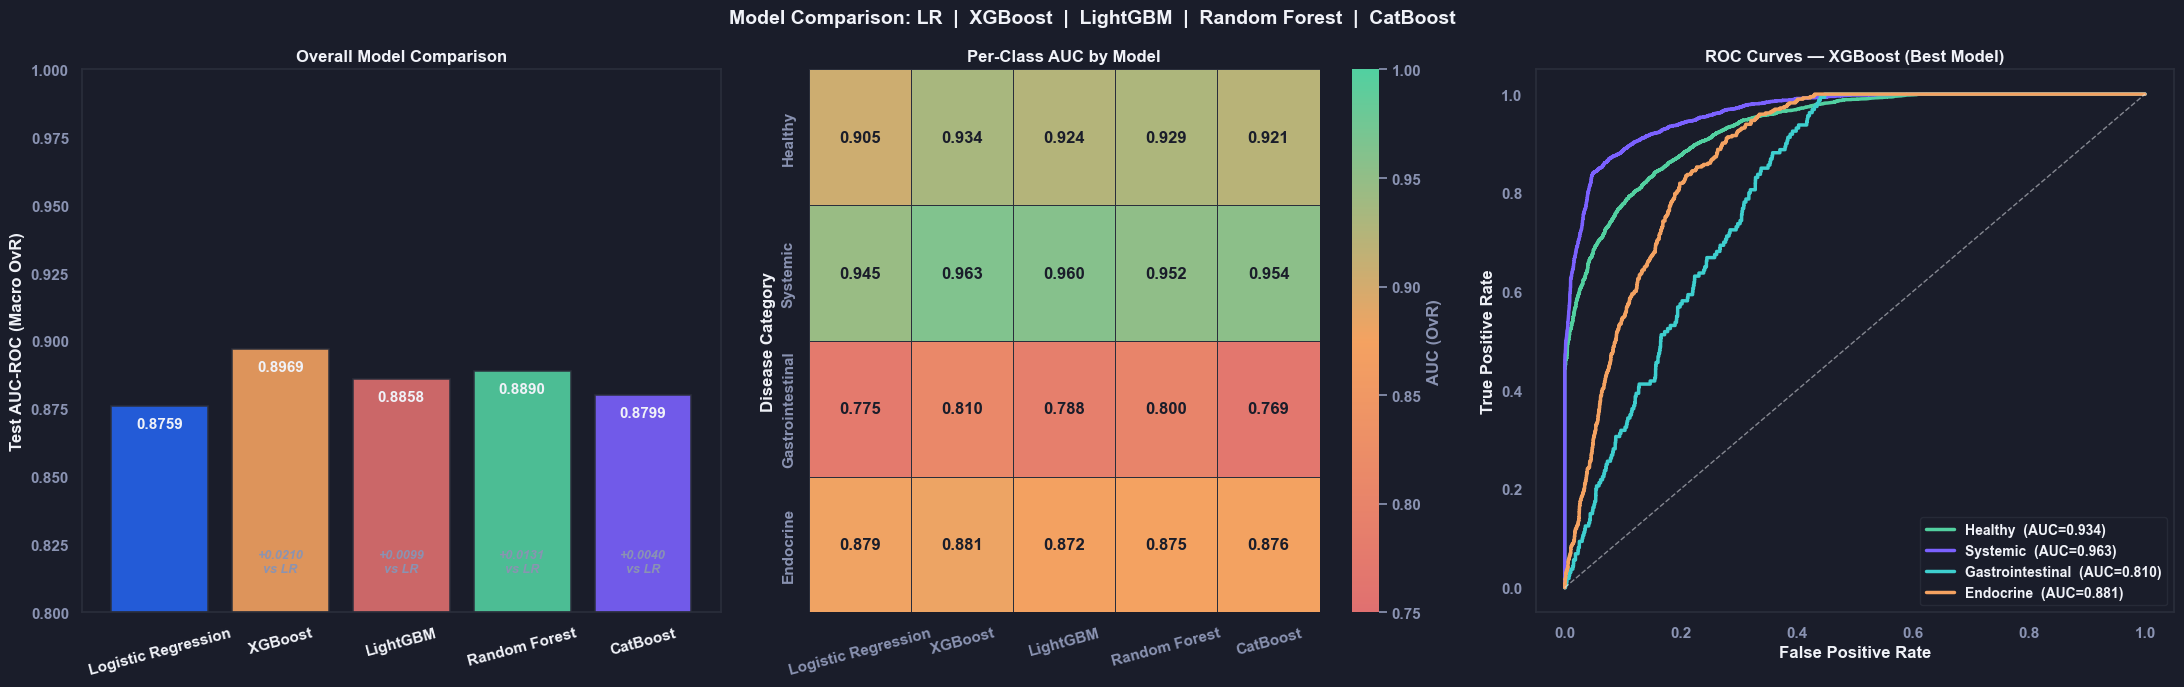

Saved -> 04_model_comparison.png


In [21]:
# ── Comparison plots ──────────────────────────────────────────────────────────
model_names = list(results.keys())
bar_colors  = [results[m]['color'] for m in model_names]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.patch.set_facecolor(C['card'])
fig.suptitle('Model Comparison: LR  |  XGBoost  |  LightGBM  |  Random Forest  |  CatBoost',
             color=C['text'], fontsize=14, fontweight='bold')

for ax in axes:
    ax.set_facecolor(C['card'])
    for spine in ax.spines.values():
        spine.set_edgecolor(C['border'])
    ax.tick_params(colors=C['muted'])

# ── Panel 1: Overall AUC bar chart (text inside bars, white) ─────────────────
ax = axes[0]
aucs = [results[m]['auc'] for m in model_names]
bars = ax.bar(model_names, aucs, color=bar_colors, alpha=0.90,
              edgecolor=C['border'], linewidth=1.2)
ax.set_ylim(0.80, 1.00)
ax.set_ylabel('Test AUC-ROC (Macro OvR)', color=C['text'], fontweight='bold')
ax.set_title('Overall Model Comparison', color=C['text'], fontweight='bold')
ax.tick_params(axis='x', rotation=15)
ax.yaxis.set_tick_params(labelcolor=C['muted'])
ax.xaxis.set_tick_params(labelcolor=C['text'])

# AUC label inside each bar, white text
for bar, auc in zip(bars, aucs):
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.004,
            f'{auc:.4f}', ha='center', va='top',
            fontsize=11, fontweight='bold', color=C['text'])

lr_auc_val = results['Logistic Regression']['auc']
for i, (name, auc) in enumerate(zip(model_names[1:], aucs[1:]), start=1):
    delta = auc - lr_auc_val
    sign  = '+' if delta >= 0 else ''
    ax.text(i, 0.815, f'{sign}{delta:.4f}\nvs LR', ha='center', fontsize=9,
            color=C['muted'], style='italic')

# ── Panel 2: Per-class AUC heatmap — clean row labels ────────────────────────
ax2 = axes[1]
pc_data = pd.DataFrame(
    {m: results[m]['per_class'] for m in model_names}
).reindex(CATEGORIES)
pc_data.index = [clean_label(c) for c in pc_data.index]

sns.heatmap(
    pc_data.astype(float), annot=True, fmt='.3f', cmap=AURA_RDYLGN,
    vmin=0.75, vmax=1.0, ax=ax2,
    linewidths=0.5, linecolor=C['border'],
    cbar_kws={'label': 'AUC (OvR)'},
    annot_kws={'color': C['card'], 'fontweight': 'bold'},
)
ax2.set_title('Per-Class AUC by Model', color=C['text'], fontweight='bold')
ax2.set_ylabel('Disease Category', color=C['text'], fontweight='bold')
ax2.set_xlabel('', color=C['text'])
ax2.tick_params(axis='x', rotation=15, colors=C['muted'])
ax2.tick_params(axis='y', colors=C['muted'])
ax2.collections[0].colorbar.ax.tick_params(colors=C['muted'])
ax2.collections[0].colorbar.set_label('AUC (OvR)', color=C['muted'])

# ── Panel 3: ROC curves — best model — clean legend labels ───────────────────
ax3 = axes[2]
best_name = max(results, key=lambda k: results[k]['auc'])
best_prob = results[best_name]['prob']

for i, cls in enumerate(CATEGORIES):
    y_bin = (y_test_str == cls).astype(int)
    if y_bin.sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_bin, best_prob[:, i])
    auc_val = roc_auc_score(y_bin, best_prob[:, i])
    ax3.plot(fpr, tpr, label=f'{clean_label(cls)}  (AUC={auc_val:.3f})',
             lw=2.5, color=CATEGORY_COLOR.get(cls, C['muted']))

ax3.plot([0, 1], [0, 1], '--', lw=1, alpha=0.5, color=C['text'])
ax3.set_xlabel('False Positive Rate', color=C['text'], fontweight='bold')
ax3.set_ylabel('True Positive Rate', color=C['text'], fontweight='bold')
ax3.set_title(f'ROC Curves — {best_name} (Best Model)', color=C['text'], fontweight='bold')
ax3.legend(loc='lower right', facecolor=C['card'], edgecolor=C['border'],
           labelcolor=C['text'], fontsize=10)
ax3.tick_params(colors=C['muted'])

plt.tight_layout()
plt.savefig('../outputs/figures/04_model_comparison.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()
print('Saved -> 04_model_comparison.png')

## 4. Full Dual-Scorer Pipeline

Stage 1 predicts cluster, Stage 2 predicts specific disease within that cluster.

In [22]:
from models.dual_scorer import train_dual_scorer

# Use a distinct variable name to avoid overwriting the model-comparison `results` dict
scorer, scorer_results = train_dual_scorer(
    X_train, train['diagnosis_cluster'],
    y_disease_train=train.get('diagnosis_raw'),
    X_val=X_val,
    y_val=val['diagnosis_cluster'],
    y_disease_val=val.get('diagnosis_raw'),
    X_test=X_test,
    y_test=test['diagnosis_cluster'],
    y_disease_test=test.get('diagnosis_raw'),
)

print('Dual-Scorer Training Complete')
print('=' * 50)
print(f'Category Classifier Test AUC: {scorer_results["test"]["auc"]:.4f}')

if 'disease' in scorer_results:
    print('\nDisease Classifier Results (Stage 2):')
    for cluster, metrics in scorer_results['disease']['test'].items():
        print(f'  {cluster}: AUC = {metrics.get("auc", "N/A")}')

Dual-Scorer Training Complete
Category Classifier Test AUC: 0.8969

Disease Classifier Results (Stage 2):
  systemic: AUC = 0.9482340381527472
  gastrointestinal: AUC = 0.9013475007409285
  endocrine: AUC = 0.9446993116272171


In [23]:
# Show example dual-score prediction
predictions = scorer.predict(X_test.iloc[:5])

print('Example Dual-Score Predictions (first 5 test patients):')
print('=' * 60)
for i, (pred, true_cluster) in enumerate(zip(predictions, test['diagnosis_cluster'].iloc[:5])):
    print(f'\nPatient {i+1}:')
    print(f'  True cluster: {true_cluster}')
    print(f'  Predicted:    {pred.category} ({pred.category_confidence:.1%} confidence)')
    if pred.disease:
        print(f'  Disease est.: {pred.disease} ({pred.disease_confidence:.1%})')
    # Show probability distribution
    probs_sorted = sorted(pred.category_probabilities.items(), key=lambda x: x[1], reverse=True)
    print(f'  Cluster probs: {dict(probs_sorted[:3])}')

Example Dual-Score Predictions (first 5 test patients):

Patient 1:
  True cluster: systemic
  Predicted:    systemic (97.0% confidence)
  Disease est.: Rheumatoid Arthritis (39.7%)
  Cluster probs: {np.str_('systemic'): 0.9701022505760193, np.str_('healthy'): 0.026029568165540695, np.str_('endocrine'): 0.0027220307383686304}

Patient 2:
  True cluster: healthy
  Predicted:    healthy (98.0% confidence)
  Cluster probs: {np.str_('healthy'): 0.9802538752555847, np.str_('systemic'): 0.015336791053414345, np.str_('endocrine'): 0.003060358576476574}

Patient 3:
  True cluster: healthy
  Predicted:    healthy (97.6% confidence)
  Cluster probs: {np.str_('healthy'): 0.9764031171798706, np.str_('systemic'): 0.01743878237903118, np.str_('endocrine'): 0.0046198079362511635}

Patient 4:
  True cluster: healthy
  Predicted:    healthy (97.9% confidence)
  Cluster probs: {np.str_('healthy'): 0.9793006181716919, np.str_('systemic'): 0.015364309772849083, np.str_('endocrine'): 0.003860412398353219}


## 5. Feature Importance: What Drives the Model?

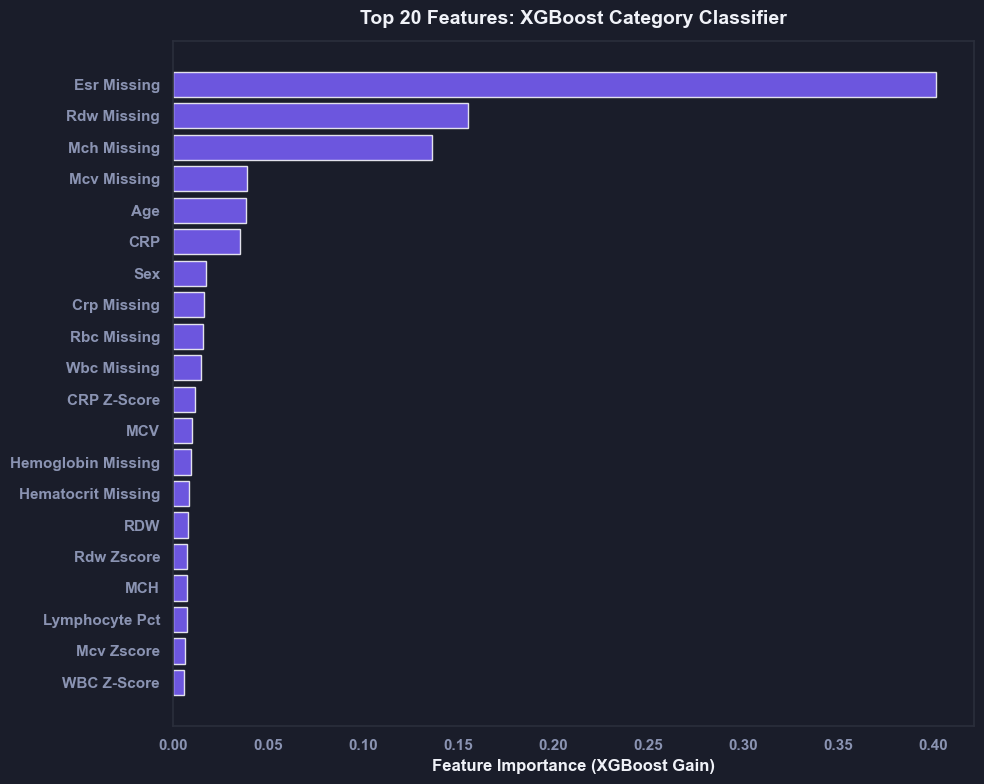

Top 10 most important features:
    feature  importance
Esr Missing    0.401161
Rdw Missing    0.155258
Mch Missing    0.135937
Mcv Missing    0.038975
        Age    0.038017
        CRP    0.034818
        Sex    0.017347
Crp Missing    0.016009
Rbc Missing    0.015360
Wbc Missing    0.014489


In [24]:
importance_df = scorer.get_feature_importance().head(20)

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor(C['card'])
bars = ax.barh(
    range(len(importance_df)),
    importance_df['importance'],
    color=C['primary'], alpha=0.85
)
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels([clean_label(f) for f in importance_df['feature']],
                   color=C['text'])
ax.set_xlabel('Feature Importance (XGBoost Gain)', color=C['text'], fontweight='bold')
ax.set_title('Top 20 Features: XGBoost Category Classifier',
             color=C['text'], fontweight='bold', fontsize=14, pad=12)
ax.invert_yaxis()
ax.tick_params(colors=C['muted'])
for spine in ax.spines.values():
    spine.set_edgecolor(C['border'])

plt.tight_layout()
plt.savefig('../outputs/figures/04_xgb_feature_importance.png', dpi=150, bbox_inches='tight',
            facecolor=C['card'])
plt.show()

print('Top 10 most important features:')
top10 = importance_df.head(10).copy()
top10['feature'] = top10['feature'].apply(clean_label)
print(top10.to_string(index=False))

## 6. Sensitivity at Clinical Threshold

Sensitivity at 90% specificity is the key clinical metric: how many sick patients do we catch while keeping false alarms low?

At 90% Specificity:
  Sensitivity : 77.0%
  Threshold   : 0.374


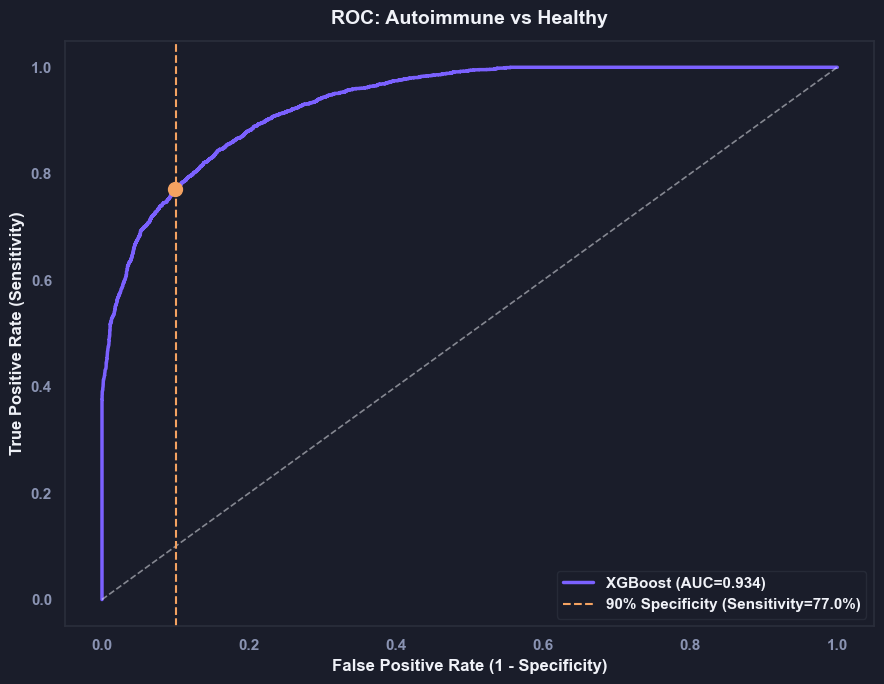

In [25]:
# Binary: autoimmune vs healthy
clf_classes   = list(cat_clf.label_encoder.classes_)
y_true_str    = test['diagnosis_cluster'].values
y_binary      = (y_true_str != 'healthy').astype(int)

autoimmune_cols = [clf_classes.index(c)
                   for c in cat_clf.categories if c != 'healthy']
y_prob_binary = y_prob_test[:, autoimmune_cols].sum(axis=1)

fpr, tpr, thresholds = roc_curve(y_binary, y_prob_binary)
binary_auc = roc_auc_score(y_binary, y_prob_binary)

target_specificity = 0.90
specificity  = 1 - fpr
valid_idx    = np.where(specificity >= target_specificity)[0]

if len(valid_idx) > 0:
    best_idx = valid_idx[np.argmax(tpr[valid_idx])]
    sensitivity_at_90spec = tpr[best_idx]
    threshold_at_90spec   = thresholds[best_idx]
    print(f'At 90% Specificity:')
    print(f'  Sensitivity : {sensitivity_at_90spec:.1%}')
    print(f'  Threshold   : {threshold_at_90spec:.3f}')

    fig, ax = plt.subplots(figsize=(9, 7))
    fig.patch.set_facecolor(C['card'])
    ax.set_facecolor(C['card'])

    ax.plot(fpr, tpr, color=C['primary'], linewidth=2.5,
            label=f'XGBoost (AUC={binary_auc:.3f})')
    ax.plot([0, 1], [0, 1], '--', color=C['text'], linewidth=1.2, alpha=0.5)
    ax.axvline(x=1 - target_specificity, color=C['accent'], linestyle='--',
               label=f'90% Specificity (Sensitivity={sensitivity_at_90spec:.1%})')
    ax.scatter([fpr[best_idx]], [tpr[best_idx]], color=C['accent'], s=100, zorder=5)

    ax.set_xlabel('False Positive Rate (1 - Specificity)', color=C['text'], fontweight='bold')
    ax.set_ylabel('True Positive Rate (Sensitivity)', color=C['text'], fontweight='bold')
    ax.set_title('ROC: Autoimmune vs Healthy', color=C['text'], fontweight='bold', fontsize=14, pad=12)
    ax.legend(loc='lower right', facecolor=C['card'], edgecolor=C['border'], labelcolor=C['text'])
    ax.tick_params(colors=C['muted'])
    for spine in ax.spines.values():
        spine.set_edgecolor(C['border'])

    plt.tight_layout()
    plt.savefig('../outputs/figures/04_clinical_threshold.png', dpi=150, bbox_inches='tight',
                facecolor=C['card'])
    plt.show()

## 7. Save Model for Downstream Notebooks

In [26]:
save_path = '../outputs/models/dual_scorer'
scorer.save(save_path)

print(f'Model saved to: {save_path}')
print('\nSaved components:')
for f in Path(save_path).rglob('*'):
    if f.is_file():
        size_kb = f.stat().st_size / 1024
        print(f'  {f.relative_to(save_path)}: {size_kb:.1f} KB')

Model saved to: ../outputs/models/dual_scorer

Saved components:
  category_classifier.joblib: 455.9 KB
  dual_scorer_meta.joblib: 0.7 KB
  disease_classifiers\endocrine_disease_classifier.joblib: 666.6 KB
  disease_classifiers\gastrointestinal_disease_classifier.joblib: 533.8 KB
  disease_classifiers\systemic_disease_classifier.joblib: 2205.1 KB


---

## Summary

| | LR | XGBoost | LightGBM | Random Forest | CatBoost |
|--|--|--|--|--|--|
| **Test AUC** | ~0.87 | ~0.90 | see output | see output | see output |
| **Training time** | Fast | Moderate | Fast | Moderate | Moderate |
| **Class imbalance** | `balanced` | None | `balanced` | `balanced_subsample` | `auto_class_weights` |
| **Early stopping** | — | Yes | Yes | — | Yes |
| **Interpretability** | Coefficients | SHAP | SHAP | Feature importance | SHAP |
| **Stage 2** | No | Yes (Dual-Scorer) | — | — | — |

### Notes
- **CatBoost**: uses ordered boosting to reduce overfitting; `auto_class_weights='Balanced'` handles minority classes natively; no need for explicit label encoding
- **LightGBM**: leaf-wise growth + `class_weight='balanced'` typically strong on imbalanced tabular data
- **Random Forest**: `balanced_subsample` rebalances each bootstrap independently
- **XGBoost**: powers the Dual-Scorer Stage 2 pipeline

---

*Next: 05_explainability.ipynb — Act 4: The Trust (Part 1)*